# Demand forecasting using RNN with LSTM on PyTorch
In this tutorial, we will use the <a href="https://github.com/ray-project/ray_lightning">Ray Lightning plugin</a> (which runs on top <a href="https://docs.ray.io">Ray</a>) to speed up training and inference of Google's <a href="https://github.com/google-research/google-research/tree/master/tft">TemporalFusionTransformer</a> algorithm for RNN with LSTM, which has been adapted by <a href="https://pytorch-forecasting.readthedocs.io">PyTorch Forecasting</a>, which in turn is built on <a href="https://pytorch-lightning.readthedocs.io">PyTorch Lightning</a>. PyTorch Lightning is a set of APIs to simplify PyTorch, similar to the relationship of Keras to TensorFlow.

Ray can take any Python code and enable it to run distributed across multiple compute nodes.  The compute node cluster could be your own laptop cores or a cluster in any cloud.  Together with <a href="https://www.anyscale.com/">Anyscale cluster management</a>  for cloud, this is how Ray can speed up AI training and inferencing.

Demo data is NYC yellow taxi from: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page.  A cleaned, aggregated hourly sample is provided with this demo in this repo: <b>See data/clean_taxi_hourly.parquet</b>

Forecast goal:  Given 8 months historical taxi trips data for NYC, predict #pickups at each location, at an hourly granularity, for the next week.

Suggestion: Make a copy of this notebook. Make edits and run in the copied notebook. This way you will retain the original, executed notebook outputs.  

In [ ]:
###########
# Install libraries
###########

# !pip install fastparquet #read parquet files
# !pip install tblib  #Serialization library for Exceptions and Tracebacks
# !conda install -y grpcio #only if on Apple M1 chip, since pip can't find otherwise
# !pip install ray     #install ray for the first time
# !pip install -U ray  #update ray to latest v1.9
# !pip install pytorch_lightning==1.4 #PyTorch Lightning restricted to older version for Ray
# !conda install -y pytorch torchvision -c pytorch  #PyTorch
# !pip install ray_lightning  #PyTorch Lightning plugin for Ray
# !pip install anyscale  #run Ray code on any cloud

# Special instructions to install pytorch_forecasting
# !pip install poetry-core==1.0.7
# !pip install poetry-dynamic-versioning==0.13.1
# Experimental use my copy to get rid of warning messages about numpy
# !pip install git+https://github.com/christy/my-copy-pytorch-forecasting@main
# Official version works but gives extra warning messages
# !pip install git+https://github.com/jdb78/pytorch-forecasting@maintenance/pip-install

# Extra install for Tensorboard to work with PyTorch
# conda install -y tensorflow


In [3]:
###########
# Import libraries
###########

# Basic Python
import sys # Python sys functions
import os  # Python os functions
import logging # Python logging functions
import warnings # Python warnings
warnings.filterwarnings("ignore")  # don't show warnings
import fastparquet  # Engine for parquet support

# Open-source libraries:
import numpy as np # Numerical processing
import pandas as pd  # Dataframe (tabular data) processing
import matplotlib as plt # Graph plotting
# stop warnings from pyotorch_forecasting too many open plots
plt.rcParams.update({'figure.max_open_warning': 0})
import ray                # Run distributed code
# from ray.train import Trainer # Ray parallelization for AI algorithms

# PyTorch, PyTorch Lightning, and PyTorch Forecasting
import torch  #Pytorch
import pytorch_lightning as pl  #PyTorch Lightning convenience APIs for PyTorch
import pytorch_forecasting as ptf #PyTorch Forecasting convenience APIs for PyTorch Lightning
from ray_lightning import RayPlugin #Ray plugin to parallelize Pytorch Lightning
pl.seed_everything(415)  # Set global random seed

# PyTorch visualization uses Tensorboard
import tensorflow as tf #Tensorflow
import tensorboard as tb  #Tensorboard
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile  #compatibility for PyTorch

!python --version
print(f"pytorch: {torch.__version__}")
print(f"pytorch_lightning: {pl.__version__}")
print(f"pytorch_forecasting: {ptf.__version__}")
print(f"ray: {ray.__version__}")


Global seed set to 415


Python 3.8.12
pytorch: 1.10.1
pytorch_lightning: 1.4.0
pytorch_forecasting: 0.0.0-post.3+cd26c7c
ray: 1.9.0


# Instructions

In the cell below, set the variables to choose between:

<ul>
    <li><b>REGULAR_PYTHON = True:</b> Do not do any Ray parallelization of your Python code.  RAY_SMOKE_TEST will be ignored.</li>
    <li><b>REGULAR_PYTHON = False:</b> Use Ray engine to parallelize your code.  The Ray engine will run locally or in a cloud based on RAY_SMOKE_TEST values.</li>
    <ul>
        <li><b>RAY_SMOKE_TEST = True:</b>  Ray engine will run locally.</li>
        <li><b>RAY_SMOKE_TEST = False:</b>  Ray engine will run in a cloud using Anyscale.</li>
    </ul>
        </ul>


In [4]:
# Set these variable to True or False

# Regular python = True means no parallelization using Ray
REGULAR_PYTHON = False

# Smoke test = True means run Ray on your laptop
# Smoke test = False means run Ray on a cloud
RAY_SMOKE_TEST = True

# Anyscale cluster_name and cluster_config
CLUSTER_NAME = "christy-pytorch88"
CLUSTER_CONFIG = "christy-forecast-pytorch:13"


In [5]:
###########
# Initialize Ray using above variable choices
# Default location for ray dashboard: http://127.0.0.1:8267
# More details:  https://docs.ray.io/en/latest/ray-dashboard.html
###########

ray.shutdown()  # shutdown in case already running

if not REGULAR_PYTHON:

    if RAY_SMOKE_TEST:
        # Run Ray locally on your laptop
        print("You are running Ray Local")

        AVAILABLE_LOCAL_CPU = os.cpu_count()
        print(f"Found available CPU: {AVAILABLE_LOCAL_CPU}")

        # ray.init(fixed num_cpu)
        ray.init(
            # prevent errors in case re-running notebook
            ignore_reinit_error=True,
            num_cpus=AVAILABLE_LOCAL_CPU,
        )

    else:
        # Run Ray on any cloud using Anyscale
        print("You are running Ray on a Cloud")

        import anyscale

        # ray.init(Anyscale_cluster, cluster_config)
        ray.init(
            f"anyscale://{CLUSTER_NAME}",
            cluster_env=CLUSTER_CONFIG,
            # quiet logging settings
            log_to_driver=False,
            configure_logging=True,
            logging_level=logging.ERROR,
        )


You are running Ray Local
Found available CPU: 8


In [6]:
# Define functions
# Todo: Move functions inside util.py

# Convert data from pandas to PyTorch tensors.
def convert_pandas_pytorch_timeseriesdata(
    input_data_pandas_df:pd.Dataframe, 
    config:dict
) -> Union['pytorch_forecasting.data.timeseries.TimeSeriesDataSet',
           'torch.utils.data.dataloader.DataLoader']:

    """Converts pandas dataframe into TimeSeries folded tensors following 
       the backtesting technique.  A generator for doing the folding is 
       per batch also created.  One for the training data.  
       Another for the validation data.  

    Inputs:
        pd.Dataframe: All the input data
        dict: config is a configuration file containing hard-coded settings.

    Returns:
        'pytorch_forecasting.data.timeseries.TimeSeriesDataSet': training data
        'torch.utils.data.dataloader.DataLoader': training data loader
        'torch.utils.data.dataloader.DataLoader': validation data loader
    """
    
    # specify data parameters
    FORECAST_HORIZON = config.get("forecast_horizon", 168)
    CONTEXT_LENGTH = config.get("context_length", 63)
    BATCH_SIZE = config.get("batch_size", 32)
    NUM_WORKERS = config.get("num_dataloader_workers", 4)
    id_col_name = "pulocationid"
    target_value = "trip_quantity"
    
    the_df = input_data_pandas_df.copy()
    
    # define forecast horizon and training cutoff
    max_prediction_length = FORECAST_HORIZON  #decoder length = 1 week forecast horizon
    max_encoder_length = CONTEXT_LENGTH  # window or context length
    training_cutoff = the_df["time_idx"].max() - max_prediction_length

    # convert pandas to PyTorch tensor
    training_data = ptf.data.TimeSeriesDataSet(
        the_df[lambda x: x.time_idx <= training_cutoff],
        allow_missing_timesteps=True,
        time_idx="time_idx",
        target=target_value,
        group_ids=[id_col_name],
        min_encoder_length=5,  # min 5 historical values must exist
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=[id_col_name],
        # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
        static_reals=[],
        time_varying_known_categoricals=["day_hour"],
        # group of categorical variables can be treated as one variable
        # variable_groups={"special_days": special_days},  
        time_varying_known_reals=["time_idx", ],
                            # "mean_item_loc_weekday",
                            # "binned_max_item"],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=[target_value,],

        # https://pytorch-forecasting.readthedocs.io/en/v0.2.4/_modules/pytorch_forecasting/data.html
        target_normalizer=ptf.data.GroupNormalizer(
            groups=["pulocationid"], 
            transformation="softplus"  #forces positive values
        ), 
        add_relative_time_idx=True, # add as feature
        add_target_scales=True, # add avg target_value as feature
        add_encoder_length=True, # add as feature
    )
    
    # create PyTorch dataloader for training
    train_loader = training_data\
                        .to_dataloader(
                            train=True, 
                            batch_size=BATCH_SIZE, 
                            num_workers=NUM_WORKERS)
    
    # create validation PyTorch data 
    # (predict=True) means make do inference using the validation data
    val_dataset = ptf.data.TimeSeriesDataSet\
                    .from_dataset(
                        training_data, 
                        data=df, 
                        predict=True, 
                        stop_randomization=True)

    # create PyTorch dataloaders for inference on validation data
    validation_loader = val_dataset\
                    .to_dataloader(
                        train=False, 
                        batch_size=BATCH_SIZE * 10, 
                        num_workers=NUM_WORKERS)
    
    # return original df converted to PyTorch tensors, and pytorch loaders
    return training_data, train_loader, validation_loader


# Define a PyTorch Lightning TemporalFusionTransformer model
def define_pytorch_model(
    train_dataset: 'pytorch_forecasting.data.timeseries.TimeSeriesDataSet', 
    config: dict, 
    ray_plugin: 'ray_lightning.ray_ddp.RayPlugin'
) -> Union['pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer',
           'pytorch_lightning.trainer.trainer.Trainer']:

    """Define a PyTorch Lightning TemporalFusionTransformer model and a 
       PyTorch Lightning trainer.  Initial values for the model are hard-
       coded in the config dictionary.

    Returns:
        'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer': model
        'pytorch_lightning.trainer.trainer.Trainer': trainer for fitting the model
    """
    
    # get the parameters from config
    NUM_GPU = config.get("num_gpus", 0)
    EPOCHS = config.get("epochs", 30)
    LR = config.get("lr", 0.01)
    HIDDEN_SIZE = config.get("hidden_size", 40)
    ATTENTION_HEAD_SIZE = config.get("attention_head_size", 4)
    HIDDEN_CONTINUOUS_SIZE = config.get("hidden_continuous_size", 1)
    DROPOUT = config.get("droupout", 0.1)
    
    print(f"learning_rate = {LR}")
    print(f"hidden_size = {HIDDEN_SIZE}")
    print(f"attention_head_size = {ATTENTION_HEAD_SIZE}")
    print(f"hidden_continuous_size = {HIDDEN_CONTINUOUS_SIZE}")

    # configure early stopping when validation loss does not improve 
    early_stop_callback = \
        pl.callbacks.EarlyStopping(
            monitor="val_loss", 
            min_delta=1e-4, 
            patience=10,   #1
            verbose=False, 
            mode="min")
    
    # configure logging
    lr_logger = pl.callbacks.LearningRateMonitor(logging_interval='epoch')
    logger = pl.loggers.TensorBoardLogger("lightning_logs")  # log results to a tensorboard

    # configure PyTorch trainer with Ray Lightning plugin
    torch_trainer = pl.Trainer(
        max_epochs=EPOCHS,
        gpus=NUM_GPU,
        # weights_summary="top",
        
        # The value at which to clip gradients. 
        # Passing gradient_clip_val=None disables gradient clipping. 
        gradient_clip_val=0.1, 
        
        # How much of training data each epoch to check for debugging purpose
        limit_train_batches=0.25,  #use 25% of training data each epoch  
        # limit_train_batches=30,  #use 30 batches of training data each epoch 
        
        # Callbacks run sequentially in the order defined here.  Except ModelCheckpoint callback
        # runs after all others to ensure all states are saved to the checkpoints.
        callbacks=[lr_logger, early_stop_callback],
        
        # how often to log, default=50
        logger=logger,
        # log_every_n_steps=50,
        # sanity check runs n batches of val before starting the training, default=2
        # num_sanity_val_steps=1,
        
        # Run "fast" mode for quick sanity check
        # Note: No trainer checkpoints will be saved in fast mode
        # fast_dev_run=True,
        
        # This is the Ray parallelizing distributed part
        # regular python - just comment out below line
        plugins=[ray_plugin]
    )
    print(f"checkpoints location: {torch_trainer.logger.log_dir}")
    

    # initialize the model
    tft = ptf.models.TemporalFusionTransformer.from_dataset(
        train_dataset,
        learning_rate=LR,
        hidden_size=HIDDEN_SIZE, # num neurons in each layer, bigger runs more slowly
        # lstm_layers=HIDDEN_LAYERS, #LSTM layers=1 by default
        attention_head_size=ATTENTION_HEAD_SIZE,  #default 4 cells in LSTM layer
        dropout=DROPOUT,
        hidden_continuous_size=HIDDEN_CONTINUOUS_SIZE,  #similar to categorical embedding size
        # 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
        # output_size=7,  
        # optimizer loss metric
        loss=ptf.metrics.QuantileLoss(),
        # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        log_interval=10,  
        reduce_on_plateau_patience=4, # reduce learning automatically
    )
    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")
    
    # return the model and trainer
    return tft, torch_trainer


# Define a calling function to read data, define model, train it
def train_func(config: dict, 
               ray_plugin: 'ray_lightning.ray_ddp.RayPlugin'
) -> Union['torch.utils.data.dataloader.DataLoader',
        'pytorch_lightning.trainer.trainer.Trainer',
        'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer',
        str]
    """Define a calling function to read data, define a model and train it.

    Inputs:
        dict: configuration dictionary with hard-coded runtime values
        'ray_lightning.ray_ddp.RayPlugin': plugin for PyTorch Lightning trainer

    Returns:
        'torch.utils.data.dataloader.DataLoader': validation data loader
        'pytorch_lightning.trainer.trainer.Trainer': trainer for fitting the model
        'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer': trained model
        str: path where Pytorch Forecasting model is stored
    """
    
    # read data into pandas dataframe
    filename = "data/clean_taxi_hourly.parquet"
    df = pd.read_parquet(filename)
    df = df[["time_idx", "pulocationid", "day_hour",
                 "trip_quantity", "mean_item_loc_weekday",
                 "binned_max_item"]].copy()

    # convert data from pandas to PyTorch tensors
    train_dataset, train_loader, validation_loader = \
        convert_pandas_pytorch_timeseriesdata(df, config)

    # define a PyTorch deep learning forecasting model
    model, trainer  = define_pytorch_model(train_dataset, 
                                           config,
                                           ray_plugin)
    model_ref = ray.put(model)

    # now train the model
    trainer.fit(
        model,
        train_dataloaders=train_loader,
        val_dataloaders=validation_loader,
    )
    
    # now use the model and check metrics on validation data
    # load the best model according to the validation loss (given that
    # we use early stopping, this is not necessarily the last epoch)
    best_model_path = trainer.checkpoint_callback.best_model_path
    print(best_model_path)
    best_tft = ptf.models.TemporalFusionTransformer.load_from_checkpoint(best_model_path)
    
    # return PyTorch DataLoader, Lightning Trainer, best model and path
    return validation_loader, trainer, best_tft, best_model_path


# Create and train a baseline model

In [10]:
%%time
# specify all the config parameters
config = {
    "forecast_horizon": 168,
    "context_length": 63,
    "num_gpus": 0,
    "batch_size": 128,
    "epochs": 2,
    "num_dataloader_workers": AVAILABLE_LOCAL_CPU,
    "lr": 0.05,
    "hidden_size": 16,
    "attention_head_size": 4,
    "hidden_continuous_size": 2,
}

# specify all the config parameters 
config = {"forecast_horizon": 168, "context_length": 63,
          "num_gpus":0, "batch_size": 128, "epochs": 2,
          "num_dataloader_workers":AVAILABLE_LOCAL_CPU,
          "lr": 0.05, "hidden_size": 16, 
          "attention_head_size": 4, "hidden_continuous_size": 2}

# read data into pandas dataframe
filename = "data/clean_taxi_hourly.parquet"
df = pd.read_parquet(filename)
df = df[
    [
        "time_idx",
        "pulocationid",
        "day_hour",
        "trip_quantity",
        "mean_item_loc_weekday",
        "binned_max_item",
    ]
].copy()

# convert data from pandas to PyTorch tensors
print(f"Input data type: {type(df)}")
train_dataset, train_loader, validation_loader = convert_pandas_pytorch_timeseriesdata(
    df, config
)
print(f"Converted data type: {type(train_dataset)}")

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(validation_loader)])
baseline_predictions = ptf.models.Baseline().predict(validation_loader)


## EVALUATE THE BASELINE MODEL
# print MAE
(actuals - baseline_predictions).abs().mean()

# 29.2463


Input data type: <class 'pandas.core.frame.DataFrame'>
Converted data type: <class 'pytorch_forecasting.data.timeseries.TimeSeriesDataSet'>
CPU times: user 8.79 s, sys: 818 ms, total: 9.61 s
Wall time: 14.6 s


tensor(29.2463)

# Train a PyTorch Lightning DL Forecast Model

In [7]:
# To set up RayTrain, you need to know how many CPU and GPU you have.
# If running on a cloud using Anyscale,
#    1. check cluster size
#       https://console.anyscale.com/o/anyscale-internal/clusters
#    2. verify size of head node
#       click link next to 'Cluster compute config'
#    3. look up how many cpu in this size instance in your cloud (e.g. aws)
#       https://aws.amazon.com/ec2/instance-types/
#    4. set num_workers=N, where N > num cpu on that instance type
#       RayPlugin(num_workers=10, ...)

if not REGULAR_PYTHON:

    if RAY_SMOKE_TEST:
        # Run Ray locally on your laptop
        print("You are running Ray Local")

        # RayPlugin(fixed_num_workers)
        plugin = RayPlugin(
            num_workers=AVAILABLE_LOCAL_CPU,
            num_cpus_per_worker=1,
            use_gpu=False,
            # add this to skip warnings
            # https://github.com/PyTorchLightning/pytorch-lightning/discussions/6761
            find_unused_parameters=False,
        )

    else:
        # Run Ray on any cloud using Anyscale
        print("You are running Ray on a Cloud")

        # To enable Anyscale autoscaling, set num_cpu greater than #cpu
        # on head node of your you cluster
        # RayPlugin(num_workers = 10)
        plugin = RayPlugin(
            num_workers=8,
            num_cpus_per_worker=1,
            use_gpu=False,
            # add this to skip warnings
            # https://github.com/PyTorchLightning/pytorch-lightning/discussions/6761
            find_unused_parameters=False,
        )


You are running Ray Local


In [11]:
%%time
# specify all the config parameters
config = {
    "forecast_horizon": 168,
    "context_length": 63,
    "num_gpus": 0,
    "batch_size": 128,
    "epochs": 2,
    "num_dataloader_workers": AVAILABLE_LOCAL_CPU,
    "lr": 0.05,
    "hidden_size": 20,
    "dropout": 0.13,
    "hidden_continuous_size": 4,
    "attention_head_size": 9,
}

# Train the model, save the validation data loader and trainer objects
validation_loader, trainer, best_model, best_model_path = train_func(config, plugin)

print(f"val data loader: {type(validation_loader)}")
print(f"trainer: {type(trainer)}")
print(f"plugin: {type(plugin)}")
print(f"best_model:{type(best_model)}")
print(f"best_model_path:{best_model_path}")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


learning_rate = 0.05
hidden_size = 20
attention_head_size = 9
hidden_continuous_size = 4
checkpoints location: lightning_logs/default/version_33
Number of parameters in network: 33.3k


(RayExecutor pid=31289) Global seed set to 415
(RayExecutor pid=31289) initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/8
(RayExecutor pid=31285) Global seed set to 415
(RayExecutor pid=31285) initializing ddp: GLOBAL_RANK: 6, MEMBER: 7/8
(RayExecutor pid=31286) Global seed set to 415
(RayExecutor pid=31286) initializing ddp: GLOBAL_RANK: 2, MEMBER: 3/8
(RayExecutor pid=31287) Global seed set to 415
(RayExecutor pid=31287) initializing ddp: GLOBAL_RANK: 1, MEMBER: 2/8
(RayExecutor pid=31283) Global seed set to 415
(RayExecutor pid=31283) initializing ddp: GLOBAL_RANK: 5, MEMBER: 6/8
(RayExecutor pid=31288) Global seed set to 415
(RayExecutor pid=31288) initializing ddp: GLOBAL_RANK: 4, MEMBER: 5/8
(RayExecutor pid=31284) Global seed set to 415
(RayExecutor pid=31284) initializing ddp: GLOBAL_RANK: 3, MEMBER: 4/8
(RayExecutor pid=31282) Global seed set to 415
(RayExecutor pid=31282) initializing ddp: GLOBAL_RANK: 7, MEMBER: 8/8
(RayExecutor pid=31283) [W ProcessGroupGloo.cpp:707] Warning: Un

Validation sanity check: 100%|██████████| 1/1 [00:34<00:00, 34.23s/it]


(RayExecutor pid=31285) Global seed set to 415
(RayExecutor pid=31286) Global seed set to 415
(RayExecutor pid=31287) Global seed set to 415
(RayExecutor pid=31282) Global seed set to 415
(RayExecutor pid=31283) Global seed set to 415
(RayExecutor pid=31288) Global seed set to 415
(RayExecutor pid=31289) Global seed set to 415
(RayExecutor pid=31284) Global seed set to 415


Epoch 0:  35%|███▍      | 130/373 [09:21<17:21,  4.29s/it, loss=3.16, v_num=33, train_loss_step=2.660]


(RayExecutor pid=31287) /Users/christy/mambaforge/envs/ray/lib/python3.8/site-packages/pytorch_forecasting/models/base_model.py:789: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
(RayExecutor pid=31287)   fig, ax = plt.subplots()
(RayExecutor pid=31288) /Users/christy/mambaforge/envs/ray/lib/python3.8/site-packages/pytorch_forecasting/models/base_model.py:789: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
(RayExecutor pid=31288)   fig, ax = plt.subplots()
(RayExecutor pid=31282) /Users/christy/mambaforge/envs/ray/lib/python3.8/site-packages/pytorch

Epoch 0: 100%|█████████▉| 372/373 [25:33<00:04,  4.11s/it, loss=2.36, v_num=33, train_loss_step=2.350]
Validating: 0it [00:00, ?it/s] 
Validating:   0%|          | 0/1 [00:00<?, ?it/s]
(RayExecutor pid=31289) 
Epoch 0: 100%|██████████| 373/373 [26:49<00:00,  4.30s/it, loss=2.36, v_num=33, train_loss_step=2.350, val_loss=2.010]
                                                         
Epoch 1: 100%|█████████▉| 372/373 [26:39<00:04,  4.29s/it, loss=1.86, v_num=33, train_loss_step=1.350, val_loss=2.010, train_loss_epoch=3.290]
Validating: 0it [00:00, ?it/s] 
Validating:   0%|          | 0/1 [00:00<?, ?it/s]
(RayExecutor pid=31289) 
Epoch 1: 100%|██████████| 373/373 [27:31<00:00,  4.42s/it, loss=1.86, v_num=33, train_loss_step=1.350, val_loss=1.540, train_loss_epoch=3.290]
                                                         
Epoch 1: 100%|██████████| 373/373 [27:32<00:00,  4.42s/it, loss=1.86, v_num=33, train_loss_step=1.350, val_loss=1.540, train_loss_epoch=3.290]
lightning_logs/defa

(RayExecutor pid=31285) /Users/christy/mambaforge/envs/ray/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 33 leaked semaphore objects to clean up at shutdown
(RayExecutor pid=31285)   warnings.warn('resource_tracker: There appear to be %d '
(RayExecutor pid=31286) /Users/christy/mambaforge/envs/ray/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 33 leaked semaphore objects to clean up at shutdown
(RayExecutor pid=31286)   warnings.warn('resource_tracker: There appear to be %d '
(RayExecutor pid=31287) /Users/christy/mambaforge/envs/ray/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 33 leaked semaphore objects to clean up at shutdown
(RayExecutor pid=31287)   warnings.warn('resource_tracker: There appear to be %d '
(RayExecutor pid=31282) /Users/christy/mambaforge/envs/ray/lib/python3.8/multiprocessing/resource_track

tensor(5.2650)
val data loader: <class 'torch.utils.data.dataloader.DataLoader'>
trainer: <class 'pytorch_lightning.trainer.trainer.Trainer'>
plugin: <class 'ray_lightning.ray_ddp.RayPlugin'>
best_model:<class 'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer'>
best_model_path:lightning_logs/default/version_33/checkpoints/epoch=1-step=743.ckpt
CPU times: user 21min 41s, sys: 5min 47s, total: 27min 28s
Wall time: 55min 51s


In [ ]:
# best_model:<class 'pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer'>
# best_model_path:lightning_logs/default/version_33/checkpoints/epoch=1-step=743.ckpt
# CPU times: user 21min 41s, sys: 5min 47s, total: 27min 28s
# Wall time: 55min 51s


# Evaluate Performance

In [71]:
## EVALUATE THE DL MODEL

# get actuals, predictions on validation data, as tensors
actuals = torch.cat([y[0] for x, y in iter(validation_loader)])
predictions = best_model.predict(validation_loader)

# raw predictions are a dictionary from which quantiles can be extracted
raw_predictions, x = best_model.predict(validation_loader, mode="raw", return_x=True)
print(type(actuals), type(predictions), type(raw_predictions))

# calculate MAE
MAE = (actuals - predictions).abs().mean()
print(f"MAE: {MAE}")

# calculate RMSE
criterion = torch.nn.MSELoss()
RMSE = torch.sqrt(criterion(actuals, predictions))
print(f"RMSE: {RMSE}")

# calculate WQL
desired_quantiles = [0.25, 0.5, 0.75]
y_quantiles = ptf.utils.to_list(
    best_model.to_quantiles(raw_predictions, desired_quantiles)
)
# overall normalized mean over all quantiles, over all items
mean = torch.mean(torch.stack(y_quantiles))
minvals, _ = torch.min(torch.stack(y_quantiles), dim=0)
min = torch.min(minvals)
maxvals, _ = torch.max(torch.stack(y_quantiles), dim=0)
max = torch.max(minvals)
WQL = (mean - min) / (max - min)
print(f"WQL: {WQL}")
# note: to get a single item quantile prediction:
# y_quantiles[1].detach().cpu()[43, : x["decoder_lengths"][43]]  #quantile p50 for itemid="140"


<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'pytorch_forecasting.models.base_model.BaseModel.to_network_output.<locals>.Output'>
MAE: 5.265017032623291
RMSE: 17.64057159423828
WQL: 0.021402491256594658


In [ ]:
# # Visualize in tensorboard, hit ctrl-c when done
# !tensorboard --logdir=lightning_logs --load_fast=false
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/
# Doesn't seem to work on Anyscale?
# (base):~/christy-forecast-pytorch/lightning_tensorboard --logdir=lightning_logs --load_fast=falseoad_fast=false
# 2021-12-16 13:21:52.644765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
# 2021-12-16 13:21:52.644793: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
# 2021-12-16 13:21:52.644818: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ses-gtzg9465hmpnyk4piy3b6nmx-head-node-type-8599797c78-4dm49): /proc/driver/nvidia/version does not exist
# Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
# TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)


# Plot actuals vs predictions

In [19]:
# Look up embedding index values of items you want to find
best_model.hparams


"attention_head_size":               9
"categorical_groups":                {}
"dropout":                           0.1
"embedding_labels":                  {'pulocationid': {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '105': 5, '106': 6, '107': 7, '108': 8, '109': 9, '11': 10, '111': 11, '112': 12, '113': 13, '114': 14, '115': 15, '116': 16, '117': 17, '118': 18, '119': 19, '12': 20, '120': 21, '121': 22, '122': 23, '123': 24, '124': 25, '125': 26, '126': 27, '127': 28, '128': 29, '129': 30, '13': 31, '130': 32, '131': 33, '132': 34, '133': 35, '134': 36, '135': 37, '136': 38, '137': 39, '138': 40, '139': 41, '14': 42, '140': 43, '141': 44, '142': 45, '143': 46, '144': 47, '145': 48, '146': 49, '147': 50, '148': 51, '149': 52, '15': 53, '150': 54, '151': 55, '152': 56, '153': 57, '154': 58, '155': 59, '156': 60, '157': 61, '158': 62, '159': 63, '16': 64, '160': 65, '161': 66, '162': 67, '163': 68, '164': 69, '165': 70, '166': 71, '167': 72, '168': 73, '169': 74, '17': 75, '170': 76

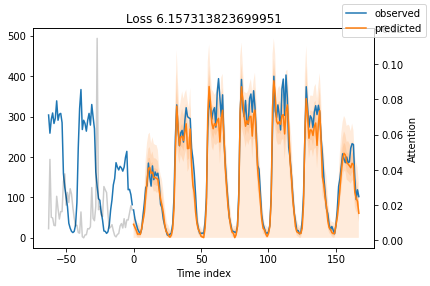

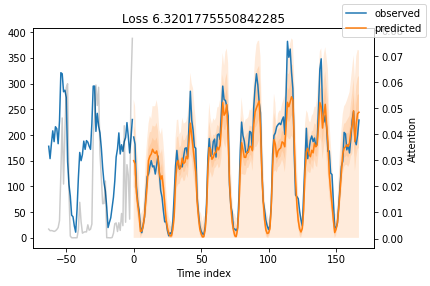

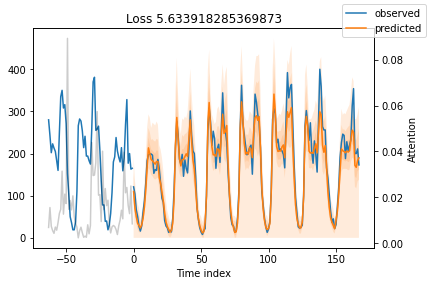

In [20]:
# Print plots for particular item ids
for idx in [43, 144, 141]:  # plot pulocationod ["140", "231", "229"]
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)


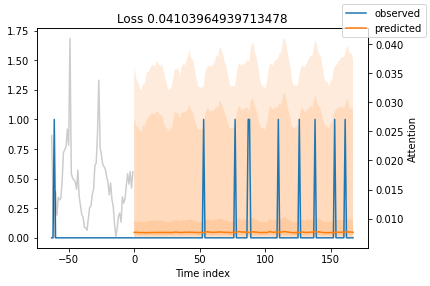

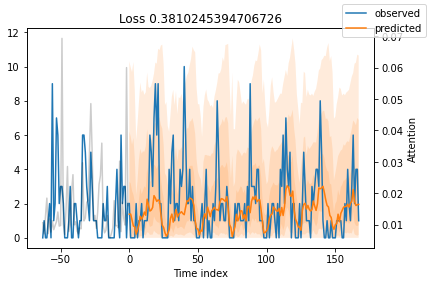

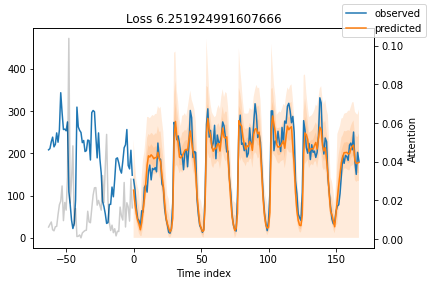

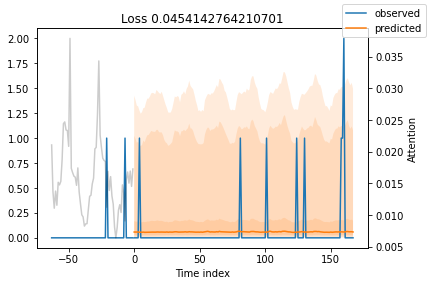

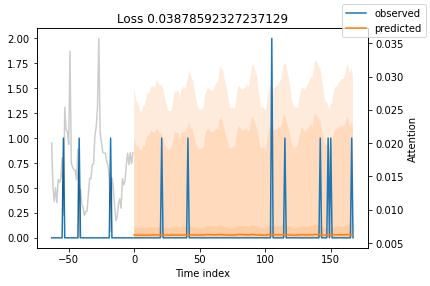

In [14]:
for idx in range(5):  # plot first 5 indexes (sort of a random sample)
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)


# Shutdown

In [ ]:
# When finished, shut down ray

if not REGULAR_PYTHON:
    ray.shutdown()
